# Trabajo de Fin de Grado - Álvaro López García
## _Grado en Ingeniería Informática_
### Facultad de Ciencias - Universidad de Cantabria


In [1]:
# Celda para importar librerías, costantes, etc.
import pandas as pd
import tensorflow as tf
import numpy as np
import pretty_midi
import mido
import string
import math
import collections
import librosa 

from IPython import display
from matplotlib import pyplot as plt

PATH = '/Volumes/TheVault/Documentos Mac/Documentos Universidad/4o Curso/2o Cuatrimestre/Trabajo de Fin de Grado/maestro-v3.0.0/'

### Creación del dataframe

In [2]:
def get_dataframe(path=PATH + 'maestro-v3.0.0.csv'):
    df = pd.read_csv(path)
    return df

In [3]:
df = get_dataframe()
df.head()

,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration
0,Alban Berg,Sonata Op. 1,train,2018,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,698.661160
1,Alban Berg,Sonata Op. 1,train,2008,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,759.518471
2,Alban Berg,Sonata Op. 1,train,2017,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,464.649433
3,Alexander Scriabin,"24 Preludes Op. 11, No. 13-24",train,2004,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,872.640588
4,Alexander Scriabin,"3 Etudes, Op. 65",validation,2006,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,397.857508


### Preprocesado del Dataset

#### Parámetros del procesado

In [4]:
# Parámetros de configuración de los archivos de audio
SAMPLING_RATE = 250
N_NOTES = 88
N_ROWS = 2

if N_ROWS is not None: 
    num = N_ROWS
else:
    num = len(df)

#### Procesado de los imputs del modelo (MIDI -> np.array)

In [5]:
# DISCLAIMER: Basado en https://medium.com/analytics-vidhya/convert-midi-file-to-numpy-array-in-python-7d00531890c

'''
    Los mensajes son eventos que, dependiendo de su tipo nos indican distinto tipo de
    informaciones acerca de lo que sucede en la pista. En este método nos quedamos sólo
    con la información que nos interesa dependiendo del tipo de mensaje.
'''
def msg2dict(msg):
    
    # Declaración de variables
    result = dict()
    key_on = bool()
    
    # Para saber si el mensaje nos indica que una nota esta pulsada en ese momento, o si
    # el mensaje no se refiere a una nota
    if msg.type == 'note_on':
        key_on = True
    elif msg.type == 'note_off':
        key_on = False
    else:
        key_on = None
        
    # Obtenemos la información relativa al tiempo
    result['time'] = msg.time
    
    # En caso de que se trate de una nota, retornamos los atributos que nos interesan
    if key_on is not None:
        result['note'] = msg.note
        result['velocity'] = msg.velocity
    
    return (result, key_on)

'''
    Actualiza el valor de una nota en un nuevo estado para unos valores de velocidad
    faciltados de entrada.
'''
def switch_note(last_state, note, velocity, key_on, n_notes=N_NOTES):
    
    # Si se trata del primer estado de la pista, creamos un array de ceros vacio
    if last_state is None:
        result = np.zeros((n_notes), dtype=int)
    else:
        result = last_state.copy()
    
    # Si la nota esta dentro de los margenes de las que estan en los valores del teclado
    # del piano y se pulsa, actualizamos su velocidad
    if 21 <= note <= 108:
        if key_on:
            result[note-21] = velocity 
        else:
            result[note-21] = 0

    return result

'''
    Devuelve un nuevo estado de acuerdo a un nuevo mensaje. Entendemos por estado, como
    un vector (array) donde cada componente representa el valor de velocidad de una de
    las teclas del piano en un instante de tiempo determinado.
'''
def get_new_state(new_msg, last_state):
    
    # Obtenemos los distintos valores y parámetros del mensaje en cuestión
    new_msg, key_on = msg2dict(new_msg)
    
    if key_on is not None: # Si el mensaje se refiere a un cambio en una nota
        new_state = switch_note(last_state, new_msg['note'], new_msg['velocity'], key_on)
    else: # En caso contrario el estado se mantiene inmutable
        new_state = last_state
    return (new_state, new_msg['time'])

'''
    Transformamos una pista (compuesta de mensajes) en un array bidimensional de estados.
    Hay que convertir los mesajes a estados (np.arrays).
'''
def track2seq(track, n_notes=N_NOTES):
    
    result = [] # Lista donde almacenaremos los distintos estados
    last_state, last_time = get_new_state(track[0], np.zeros((n_notes), dtype=int)) # Obtenemos los primeros valores de estado y tiempo
    
    for i in range(1, len(track)):
        new_state, new_time = get_new_state(track[i], last_state)
        
        if new_time > 0: # Añadimos tantas "rodajas" temporales con el ultimo estado como tiempo haya pasado desde la ultima pulsacion  
            result += [last_state] * new_time
        last_state, last_time = new_state, new_time
        
    return np.array(result)

'''
    Devuelve un array con los valores del pianoroll de todas las pistas del midi.
'''
def mid2array(mid, n_notes=N_NOTES):
    
    # Lista donde almacenaremos los valores de las distintas pistas
    all_arys = []
    
    # Calculamos cual va a ser la longitud de nuestro array
    tracks_len = [len(tr) for tr in mid.tracks]
    
    # Obtenemos los np.array(s) de cada pista
    for i in range(1, len(mid.tracks)):
        all_arys.append(track2seq(mid.tracks[i]))
    
    # Convertirmos a np.array y nos quedamos con el valor máximo de una nota de entre todas las pistas
    all_arys = np.array(all_arys)
    all_arys = all_arys.max(axis=0)

    return all_arys

'''
    Devuelve un pianorroll sampleado al ratio que se proporiciona como argumento de entrada.
'''
def resample_pianoroll(piano_roll, old_sampling_rate, new_sampling_rate):
    
    step = old_sampling_rate / new_sampling_rate
    result = []

    for i in np.arange(0.0, len(piano_roll), step):
        result.append(np.array(np.mean(np.array(piano_roll[int(i):int(i + step)]), axis=0)))

    return result

'''
    Analiza los mensajes de las pistas de un determinado archivo midi que se pasa como
    argumento de entrada para calcular su sampling rate y lo devuelve.
'''
def get_sampling_rate(midi):
    
    tpb = midi.ticks_per_beat
    t_ms = 500000 # Valor por defecto en el formato midi
    track = midi.tracks[0] # Pista que contiene metapaámetros del archivo
    
    for msg in track:
        if msg.tempo is not None:
            t_ms = msg.tempo
            break
            
    t_s = (10 ** 6) / t_ms
    return tpb * t_s

'''
    Plotea un pianoroll pasado como argumento de entrada.
'''
def plot_pianoroll(pianoroll, title=None):
    plt.figure(figsize=(16,6),dpi=200)
    plt.plot(range(pianoroll.shape[0]), np.multiply(np.where(pianoroll>0, 1, 0), range(1, N_NOTES + 1)), marker='.', markersize=1, linestyle='', color='c')
    plt.xlim(0, pianoroll.shape[0] * 1.05)
    plt.ylim(0, N_NOTES * 1.05)
    if title is not None: plt.title(title)
    plt.show()

'''
    Toma una lista de archivos MIDI y devuelve una lista de pianorolls. Tiene argumentos
    opcionales para especificar el directorio padre desde el que han de leerse los archivos
    MIDI en cuestión y la frecuencia de muestreo a la que han de devolverse.
'''
def vectorize_midis(files, sampling_rate=SAMPLING_RATE, dir_path=PATH):
    
    result = []
    for file in files:
        midi = mido.MidiFile(dir_path + file, clip=True)
        pianoroll = mid2array(midi)
        pianoroll_resampled = resample_pianoroll(pianoroll, get_sampling_rate(midi), sampling_rate)
        result.append(np.array(pianoroll_resampled))
        
    return result

(1, 175996, 88)


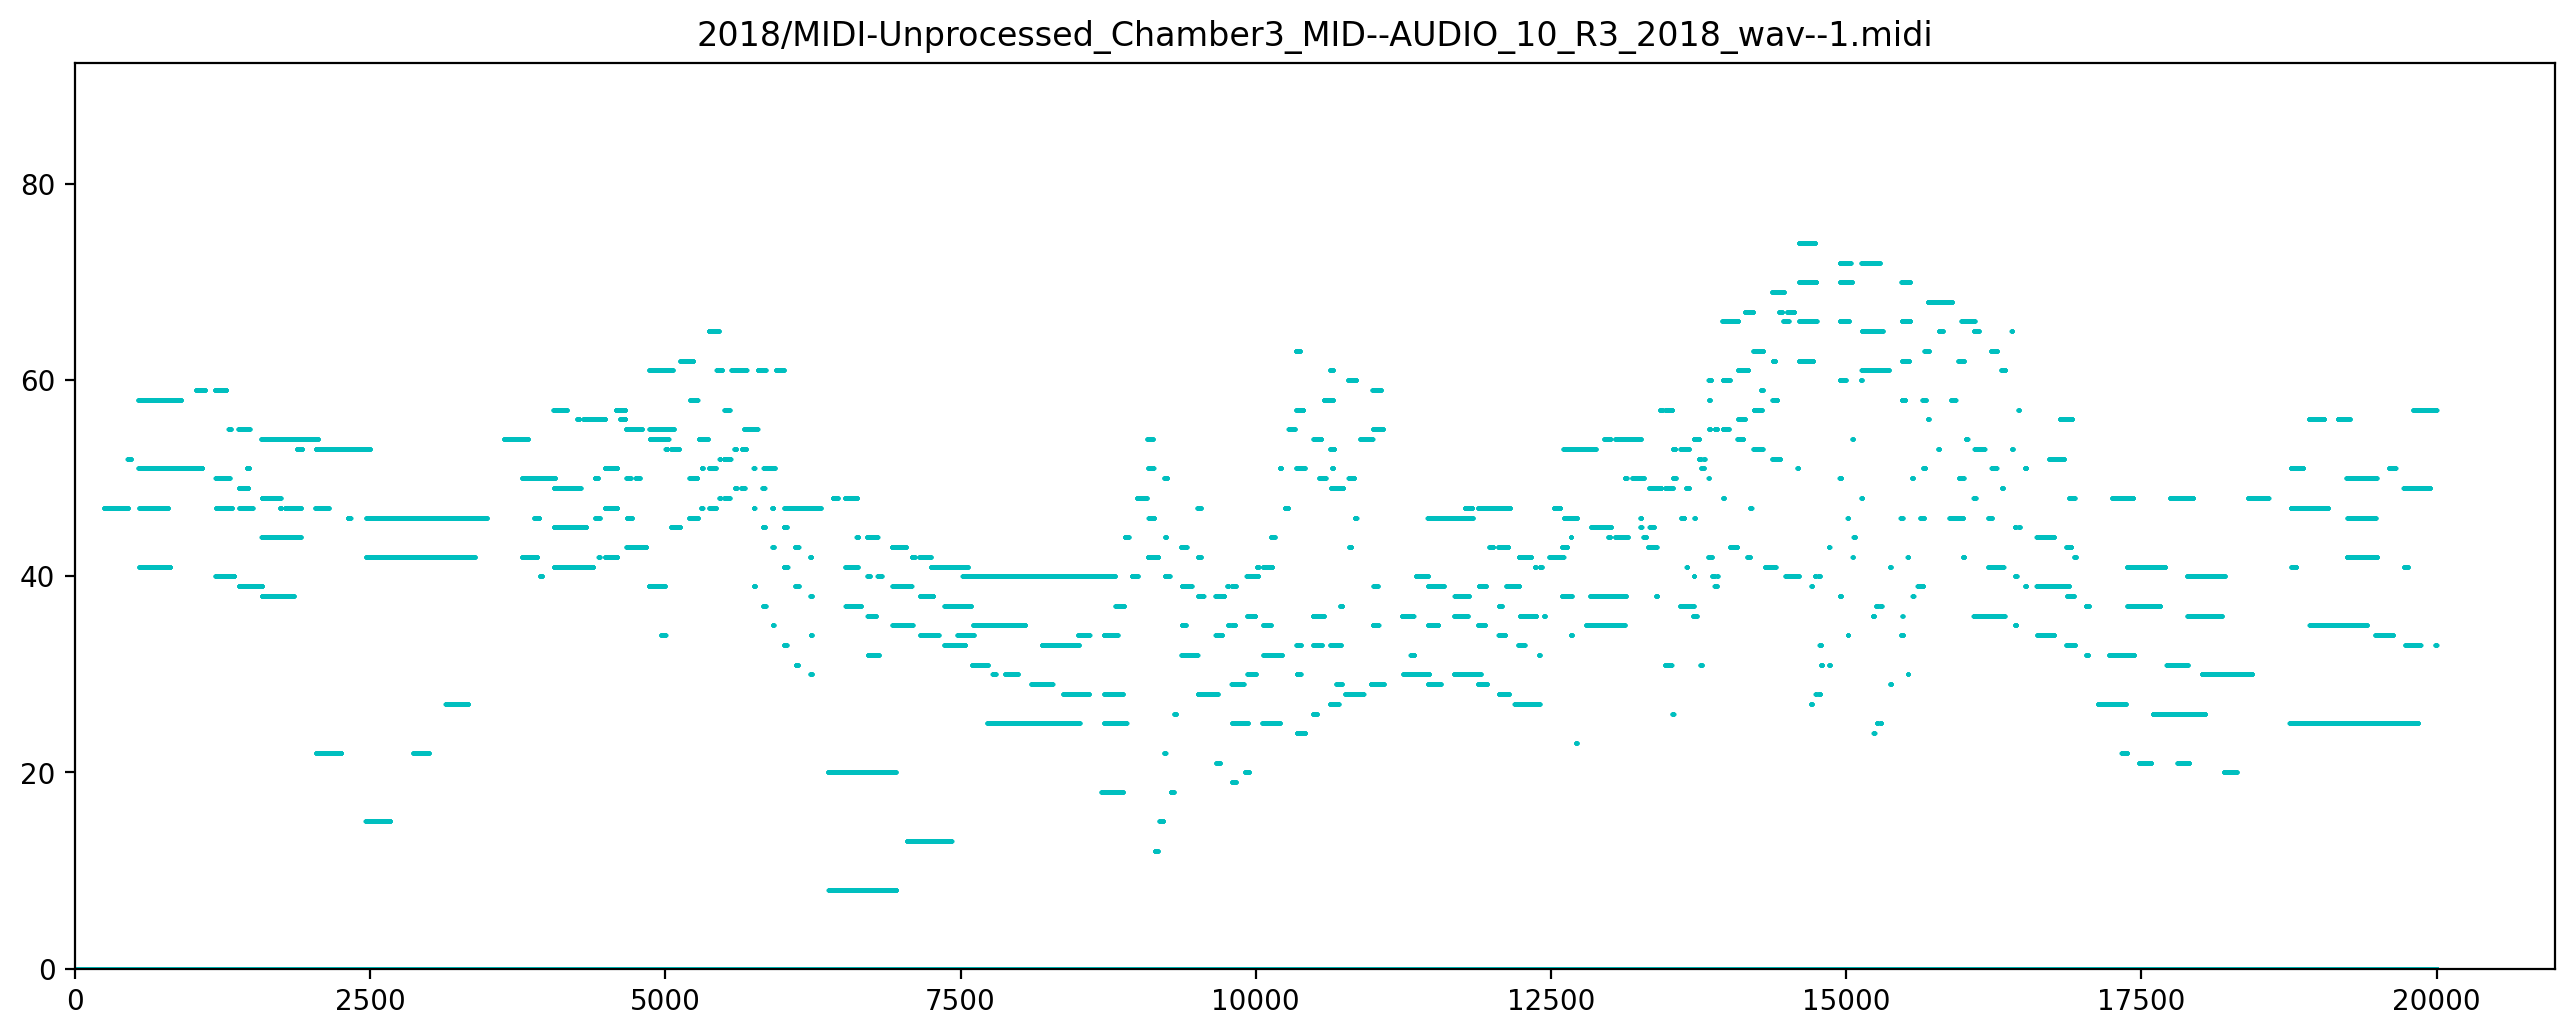

In [6]:
pianorolls = vectorize_midis(df['midi_filename'][0:1])
print(np.array(pianorolls).shape)
plot_pianoroll(pianorolls[0][0:20000], title=df['midi_filename'][0])

#### Procesado de los valores objetivo (.wav -> np.array)

In [7]:
'''
    Plotea los valores de la onda que han pasado como argumento de entrada.
'''
def plot_wav(waves, title=None):
    wave = waves.flatten()
    plt.figure(figsize=(16,6),dpi=200)
    plt.plot(wave)
    plt.xlim(0, len(wave))
    plt.ylim(min(wave) * 1.05, max(wave) * 1.05)
    if title is not None: plt.title(title)
    plt.show()
    
def split_wav(data, old_sampling_rate, new_sampling_rate):

    duration = librosa.get_duration(y=data, sr=old_sampling_rate)
    sampling_period = 1 / new_sampling_rate
    step = int(len(data) * sampling_period / duration)
    
    tail = len(data) % step
    data = data[0:-tail]
    result = data.reshape(-1, step)

    return result

'''
    Toma una lista de archivos .wav y devuelve una lista de np.arrays con los valores de la 
    onda por ventanas de tiempo. Tiene argumentos opcionales para especificar el directorio 
    padre desde el que han de leerse los archivos wac en cuestión y la frecuencia de muestreo
    a la que han de devolverse.
'''
def vectorize_wavs(files, sampling_rate=SAMPLING_RATE, dir_path=PATH):
    
    result = []
    
    for file in files:
        data, sr = librosa.load(PATH + file)
        resampled_data = split_wav(data, sr, sampling_rate)
        result.append(np.array(resampled_data))
    
    return result

(1, 176468, 88)


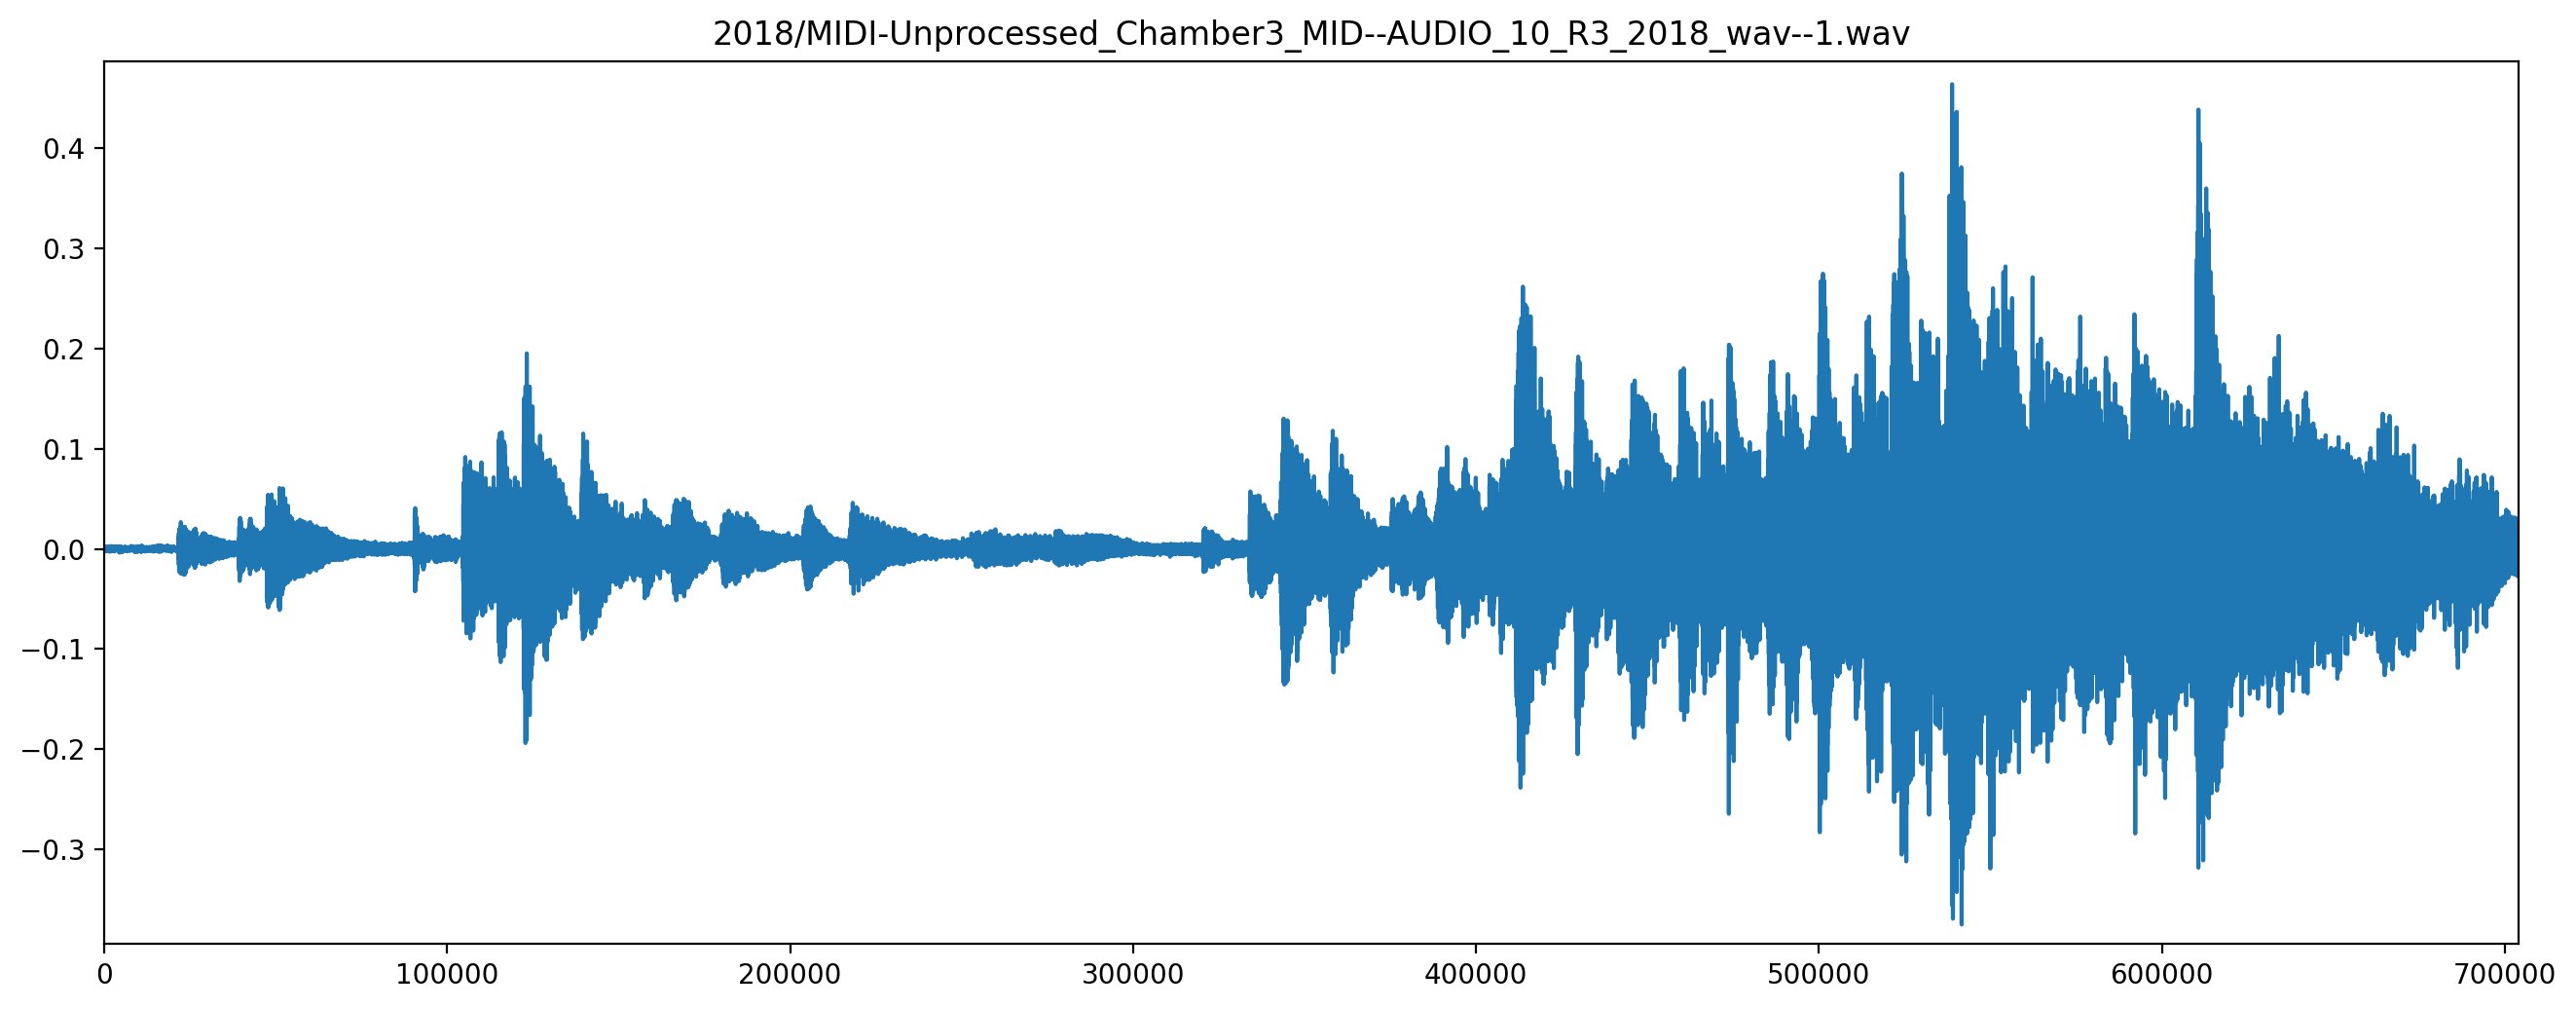

In [8]:
waves = vectorize_wavs(df['audio_filename'][0:1])
print(np.array(waves).shape)
plot_wav(waves[0][0:8000], title=df['audio_filename'][0])

#### Añadiendo los valores reales del entrenamiento del modelo al dataframe del dataset

In [9]:
X = [] # Midis
y = [] # wavs

# Añadimos una columna al dataframe con los datos de input de nuestra red (X) y nuestros 
# targets (y)
for i in range(num):
    tmp_X = vectorize_midis([df['midi_filename'][i]])[0]
    tmp_y = vectorize_wavs([df['audio_filename'][i]])[0]
    
    # Provisional hasta arreglar el tema de la precisión
    # TODO: Revisar
    max_len = min(len(tmp_X), len(tmp_y))
    print(len(tmp_X[0:max_len]), len(tmp_y[0:max_len]))
    
    X.append(tmp_X[0:max_len])
    y.append(tmp_y[0:max_len])

175996 175996
191180 191180


In [10]:
# Rellenamos con Nones las listas para machear al longitud del dataframe
X += [None] * (df.shape[0] - len(X))
y += [None] * (df.shape[0] - len(y))

df['X'] = X
df['y'] = y
df.head()

,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration,X,y
0,Alban Berg,Sonata Op. 1,train,2018,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,698.661160,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.00014418163, 0.00028806977, 0.0003007487, ..."
1,Alban Berg,Sonata Op. 1,train,2008,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,759.518471,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.00028808016, 0.00038847164, 0.00041273062,..."
2,Alban Berg,Sonata Op. 1,train,2017,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,464.649433,None,None
3,Alexander Scriabin,"24 Preludes Op. 11, No. 13-24",train,2004,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,872.640588,None,None
4,Alexander Scriabin,"3 Etudes, Op. 65",validation,2006,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,397.857508,None,None


### Creación del modelo
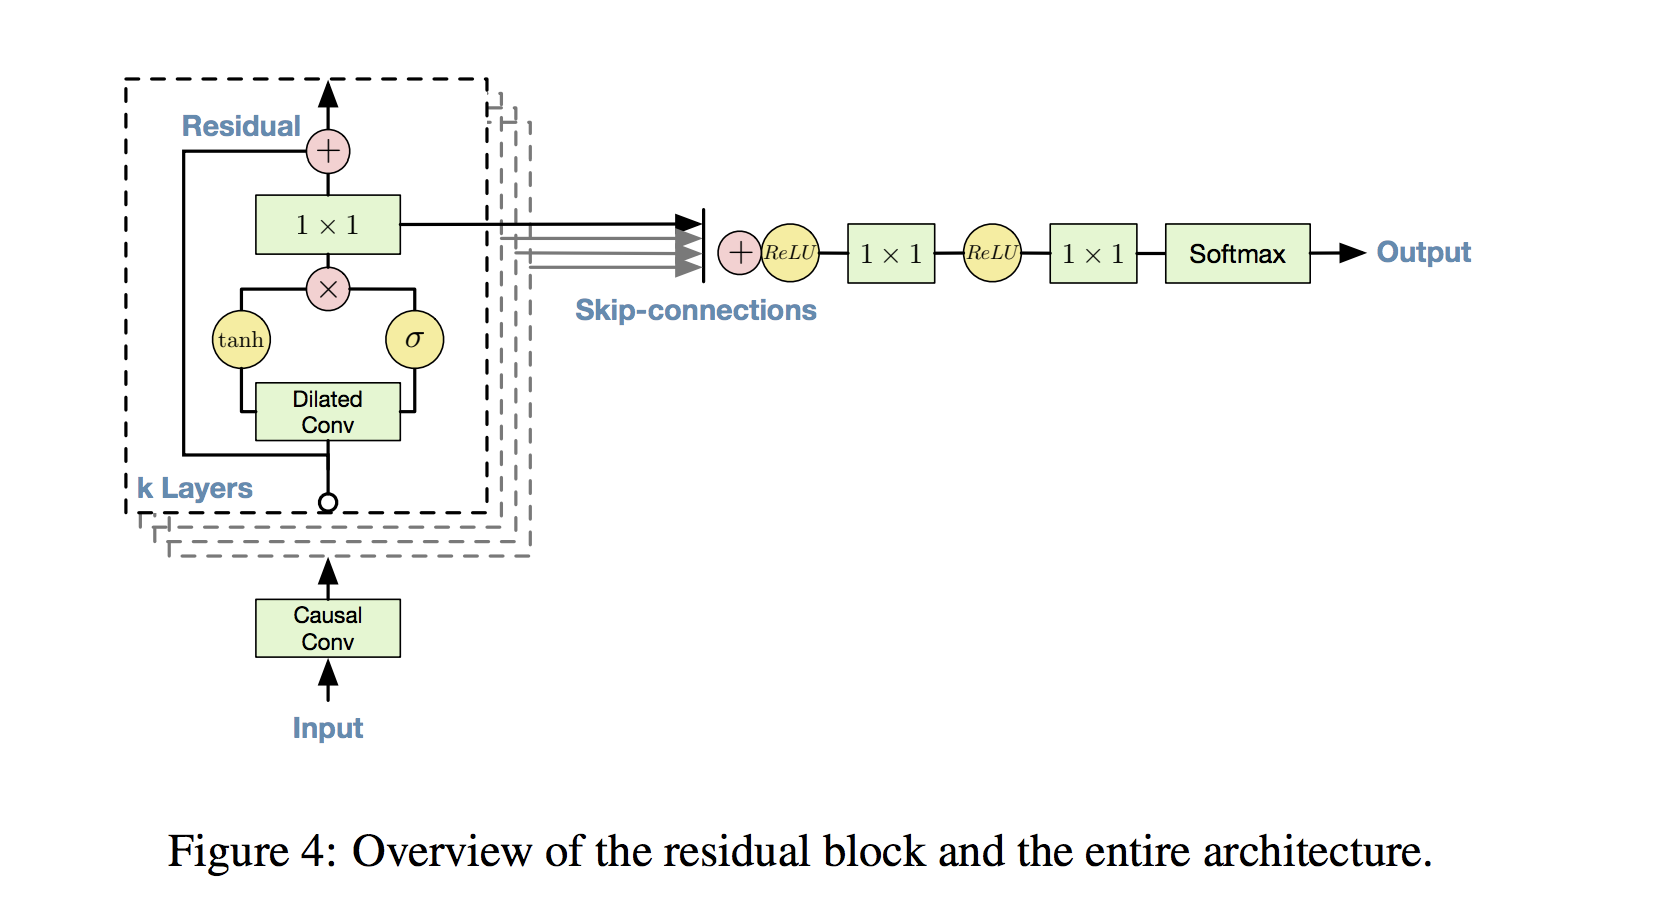

In [19]:
# Calculando parámetros para generar la arquitectura del modelo
n_input_features = N_NOTES
n_output_features = len(df['y'][0][0])

In [46]:
# Metaparámetros
n_filters = 32 
filter_width = 2
k_layers = 7
dilation_rates = [2 ** i for i in range(k_layers)] * 2
inp_shape=(1, n_input_features)
epochs = 20
batch_size = 1

# Historial de inputs (stack de capas)
Input_seq = tf.keras.layers.Input(shape=inp_shape, dtype='float32')
x = Input_seq

skips = []
for dilation_rate in dilation_rates:
    
    # Input
    x = tf.keras.layers.Conv1D(inp_shape[1], 1, padding='same', activation='relu')(x) 
    # padding='same' añade 0 en los bordes de la entrada para la convolción
    
    # Filter convolution
    x_f = tf.keras.layers.Conv1D(filters=n_filters, kernel_size=filter_width,
                                 padding='same', dilation_rate=dilation_rate)(x)

    # Gating convolution
    x_g = tf.keras.layers.Conv1D(filters=n_filters, kernel_size=filter_width,
                                 padding='same', dilation_rate=dilation_rate)(x)

    # Multiplicamos las ramas de Filter y Gating
    z = tf.keras.layers.Multiply()([tf.keras.layers.Activation('tanh')(x_f),
                                    tf.keras.layers.Activation('sigmoid')(x_g)])
    z = tf.keras.layers.Conv1D(n_output_features, 1, padding='same', activation='relu')(z)

    # Residual connection
    x = tf.keras.layers.Add()([x, z])    
    
    # Vamos añadiendo las 'Skip conections'
    skips.append(z)
    
    # x -> Residual
    # z -> Skip connections -> ...

# Sumamos todas las skip connections
out = tf.keras.layers.Activation('relu')(tf.keras.layers.Add()(skips))
model = tf.keras.models.Model(Input_seq, out)
model.compile(tf.keras.optimizers.Adam(), loss='categorical_crossentropy')
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1, 88)]      0           []                               
                                                                                                  
 conv1d_224 (Conv1D)            (None, 1, 88)        7832        ['input_5[0][0]']                
                                                                                                  
 conv1d_225 (Conv1D)            (None, 1, 32)        5664        ['conv1d_224[0][0]']             
                                                                                                  
 conv1d_226 (Conv1D)            (None, 1, 32)        5664        ['conv1d_224[0][0]']             
                                                                                            

 activation_124 (Activation)    (None, 1, 32)        0           ['conv1d_241[0][0]']             
                                                                                                  
 activation_125 (Activation)    (None, 1, 32)        0           ['conv1d_242[0][0]']             
                                                                                                  
 multiply_60 (Multiply)         (None, 1, 32)        0           ['activation_124[0][0]',         
                                                                  'activation_125[0][0]']         
                                                                                                  
 conv1d_243 (Conv1D)            (None, 1, 88)        2904        ['multiply_60[0][0]']            
                                                                                                  
 add_64 (Add)                   (None, 1, 88)        0           ['conv1d_240[0][0]',             
          

                                                                                                  
 conv1d_260 (Conv1D)            (None, 1, 88)        7832        ['add_68[0][0]']                 
                                                                                                  
 conv1d_261 (Conv1D)            (None, 1, 32)        5664        ['conv1d_260[0][0]']             
                                                                                                  
 conv1d_262 (Conv1D)            (None, 1, 32)        5664        ['conv1d_260[0][0]']             
                                                                                                  
 activation_134 (Activation)    (None, 1, 32)        0           ['conv1d_261[0][0]']             
                                                                                                  
 activation_135 (Activation)    (None, 1, 32)        0           ['conv1d_262[0][0]']             
          

 multiply_69 (Multiply)         (None, 1, 32)        0           ['activation_142[0][0]',         
                                                                  'activation_143[0][0]']         
                                                                                                  
 conv1d_279 (Conv1D)            (None, 1, 88)        2904        ['multiply_69[0][0]']            
                                                                                                  
 add_74 (Add)                   (None, 1, 88)        0           ['conv1d_227[0][0]',             
                                                                  'conv1d_231[0][0]',             
                                                                  'conv1d_235[0][0]',             
                                                                  'conv1d_239[0][0]',             
                                                                  'conv1d_243[0][0]',             
          

### Entrenamiento del modelo

In [50]:
N_TRAINING_SAMPLES = 10000 # TO DO: Quitar
train, test = df[df['split'] == 'train'], df[df['split'] == 'test']

X = []
y = []

for i in range(num):
    train_X, train_y = train['X'][i], train['y'][i]
    for X_, y_ in zip(train_X, train_y):
        X.append(X_.reshape(1, 88))
        y.append(y_.reshape(1, 88))
            
X = np.array(X)
y = np.array(y)

print(f'Comenzando el entrenamiento del modelo (shape of X: {X.shape}, shape of y: {y.shape})...')
history = model.fit(X[0:N_TRAINING_SAMPLES], y[0:N_TRAINING_SAMPLES], batch_size=batch_size, epochs=epochs)

Comenzando el entrenamiento del modelo (shape of X: (367176, 1, 88), shape of y: (367176, 1, 88))...
Epoch 1/20
10000/10000 [==============================] - 56s 6ms/step - loss: 0.0405
Epoch 2/20
10000/10000 [==============================] - 58s 6ms/step - loss: 0.0148
Epoch 3/20
10000/10000 [==============================] - 56s 6ms/step - loss: 0.0099
Epoch 4/20
10000/10000 [==============================] - 58s 6ms/step - loss: -0.0033
Epoch 5/20
10000/10000 [==============================] - 56s 6ms/step - loss: -0.0060
Epoch 6/20
10000/10000 [==============================] - 55s 6ms/step - loss: -0.0140
Epoch 7/20
10000/10000 [==============================] - 57s 6ms/step - loss: -0.0053
Epoch 8/20
10000/10000 [==============================] - 57s 6ms/step - loss: -0.0140
Epoch 9/20
10000/10000 [==============================] - 58s 6ms/step - loss: -0.0275
Epoch 10/20
10000/10000 [==============================] - 56s 6ms/step - loss: -0.0374
Epoch 11/20
10000/10000 [======

In [51]:
'''
    Helper function to plot keras history.
    https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
'''
def plot_history(history):
    # summarize history for accuracy
    '''plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('binary_accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')'''
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    #plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

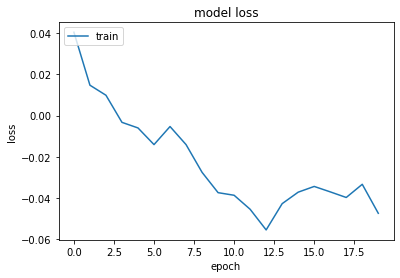

In [52]:
plot_history(history)

### Predicción

In [14]:
# foo

In [53]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))